# Cholesky and Gram-schmidt

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [5]:
%config InlineBackend.figure_format = "retina"

## The setup

### Building innovations — the Gramm-Schmidt algorithm
The innovations initialised according to
$$
\begin{aligned}
    \varepsilon_1 &= y_1,\\
    R_1 &= {\rm Var}(\varepsilon_1) = {\rm Var}(y_1).
\end{aligned}
$$
Then, 
$$
\begin{aligned}
    \varepsilon_t &= y_t - \sum_{j=1}^{t-1}{\rm Cov}(y_t, \varepsilon_j)\,R_j^{-1}\,\varepsilon_j,\\
    R_t &= {\rm Var}(\varepsilon_t).
\end{aligned}
$$

As a consequence, it can be shown that
$$
    y_{1:t} = {\bf L}\,\varepsilon_{1:t},
$$
with
$$
    {\bf L}_{t,j} =
    \begin{cases}
    {\rm Cov}(y_t, \varepsilon_j)R_j^{-1} & j=1,\ldots,t-1,\\
    {\bf I} & j=t,\\
    {\bf 0} & j > t.
    \end{cases}
$$

### The cholesky decomposition
The relationship between innovations and the Cholesky decomposition is given by the fact that
$$
    {\rm Var}(y_{1:t}) = {\bf L}\,{\bf R}\,{\bf L}^\intercal
$$
with
$$
    {\bf R} = {\rm Diag}(R_1, \ldots, R_t)
$$
and
$$
    {\bf L}_{t,j} =
    \begin{cases}
    {\rm Cov}(y_t, \varepsilon_j)R_j^{-1} & j=1,\ldots,t-1,\\
    {\bf I} & j=t,\\
    {\bf 0} & j > t.
    \end{cases}
$$

Hence,
> computation of the innovations is equivalent to computing the cholesky factorisation of ${\rm Var}(y_{1:t})$.

In [295]:
def ssm(key, signal_init, n_steps, qt, rt):
    def ssm_step(signal_prev, key):
        key_measurement, key_state = jax.random.split(key)
        ut = jax.random.normal(key_state) * qt
        et = jax.random.normal(key_measurement) * rt

        signal = signal_prev + ut
        measurement = signal + et

        return signal, (signal, measurement)

    keys = jax.random.split(key, n_steps)
    _, (signals, measurements) = jax.lax.scan(ssm_step, signal_init, keys)
    return signals, measurements

vssm = jax.vmap(ssm, in_axes=(0, None, None, None, None), out_axes=-1)

In [296]:
key = jax.random.PRNGKey(314)
key_sample, key_test = jax.random.split(key)

In [297]:
signal_init = 0.0
n_steps = 100
qt = 0.05
rt = 0.1
signals, measurements = ssm(key, signal_init, n_steps, qt, rt)

## The cholesky decompoistion

Recall:
$$
    y_{1:t} = {\bf L}\,\varepsilon_{1:t}.
$$
Then,
$$
    \varepsilon_{1:t} = {\bf L}^{-1}\,y_{1:t}.
$$

In [298]:
n_trials = 500
keys = jax.random.split(key_sample, n_trials)

In [299]:
n_steps = 100
signal_init = 0.0
rt = 0.1
qt = 0.05

signals, measurements = vssm(keys, signal_init, n_steps, qt, rt)

#### Building innovations from cholesky decomposition

In [300]:
var_y = jnp.cov(measurements)

L = jnp.linalg.cholesky(var_y)

# L = L.at[jnp.diag_indices(n_steps)].set(1.0)
R = jnp.diag(L)
L = jnp.einsum("ij,j->ij", L, 1 / R)


In [301]:
jnp.diag(var_y).sum()

Array(13.138532, dtype=float32)

In [302]:
jnp.diag(jnp.einsum("ij,j,jk->ik", L, R ** 2, L.T)).sum()

Array(13.138532, dtype=float32)

In [303]:
innovations = jnp.linalg.solve(L, measurements)

In [304]:
C = jnp.r_[signals, innovations]
C = jnp.cov(C)
C.shape

(200, 200)

In [305]:
cov_fe = C[:n_steps, n_steps:] # Cov(ft, yk)
var_e = C[n_steps:, n_steps:] # var(yt)

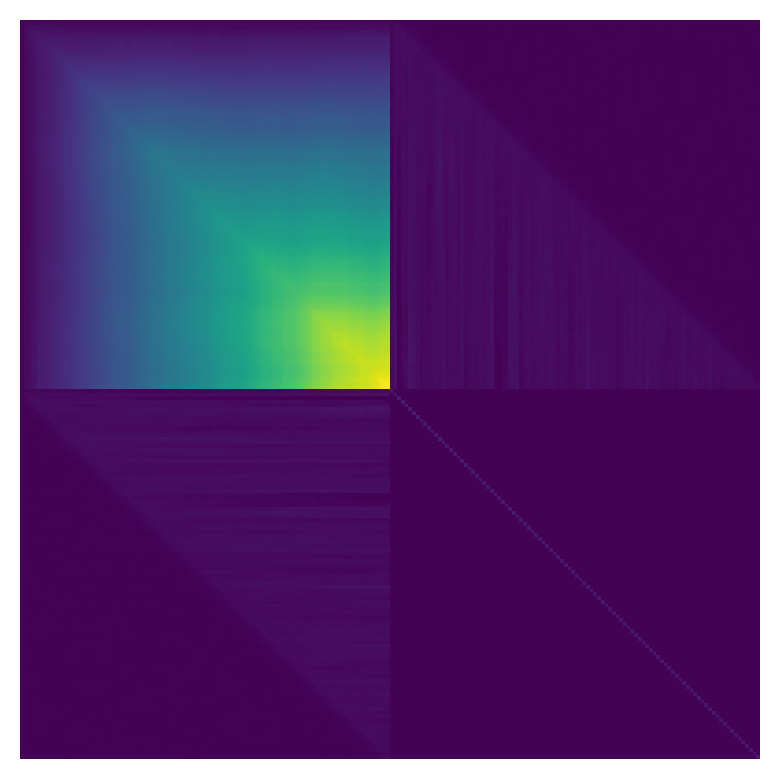

In [306]:
plt.imshow(C, cmap="viridis")
plt.axis("off");

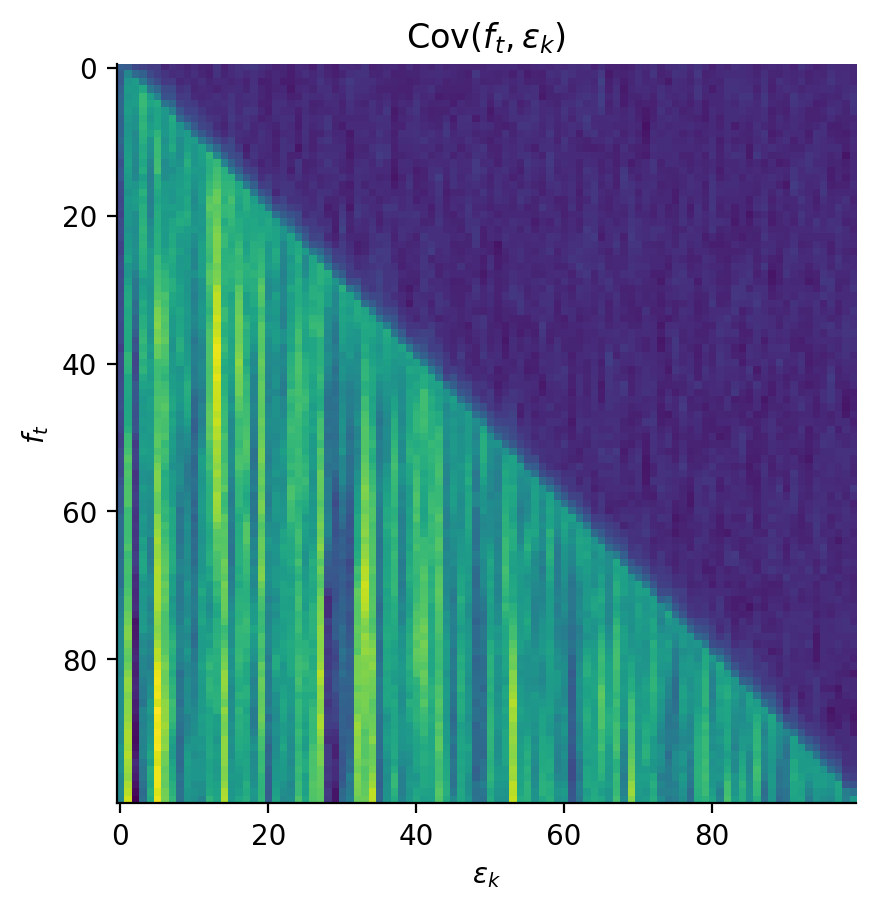

In [307]:
plt.imshow(cov_fe)
plt.title(r"${\rm Cov}(f_t, \varepsilon_k)$")
plt.xlabel(r"$\varepsilon_k$")
plt.ylabel(r"$f_t$");

## Numerical evaluation of the BLUP
(Using the innovations)

$$
\begin{aligned}
    f_{t|j}
    &= {\rm Cov}(f_t, y_{1:j})\,{\rm Var}(y_{1:j})^{-1}\,y_{1:j}\\
    &= {\rm Cov}(f_t, {\bf L}\,y_{1:j}){\rm Var}({\bf L}\,\varepsilon_{1:j})^{-1}\,{\bf L}\,\varepsilon_{1:j}\\
    &= {\rm Cov}(f_t, \varepsilon_{1:j})\,{\rm Var}(\varepsilon_{1:j})^{-1}\,\varepsilon_{1:j}\\
    &= \sum_{k=1}^j\,{\rm Cov}(f_t, \varepsilon_k)\,{\rm Var}(\varepsilon_k)^{-1}\,\varepsilon_k\\
    &= \sum_{k=1}^j\,{\rm Cov}(f_t, \varepsilon_k)\,R_k^{-1}\,\varepsilon_k\\
\end{aligned}
$$

In [308]:
n_trials_test = 20
keys_test = jax.random.split(key_test, n_trials_test)

In [309]:
signals_test, measurements_test = vssm(keys_test, signal_init, n_steps, qt, rt)

In [310]:
s = 3

In [311]:
n_trials_test = 20
keys_test = jax.random.split(key_test, n_trials_test)

In [312]:
signals_test, measurements_test = vssm(keys_test, signal_init, n_steps, qt, rt)
innovations_test = jnp.linalg.solve(L, measurements_test)

## Smoothing — $f_{t|T}$
For $t=1,\ldots,T$.

$$
    f_{t|T} = \sum_{k=1}^T\,{\rm Cov}(f_t, \varepsilon_k)\,R_k^{-1}\,\varepsilon_k\\
$$

In [313]:
xrange = jnp.arange(n_steps)

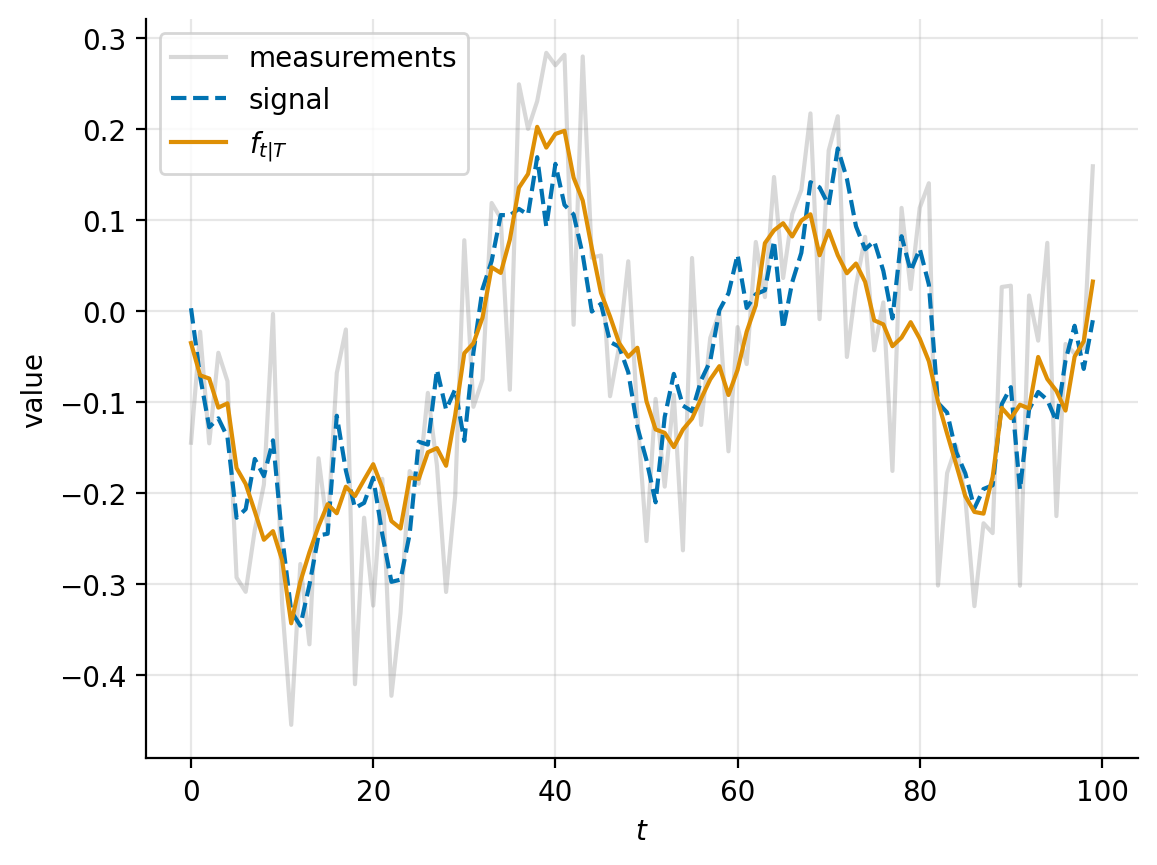

In [314]:
s = 3
blup = jnp.einsum("tk,k,k->t", cov_fe, 1 / R ** 2, innovations_test[:, s])

plt.plot(xrange, measurements_test[:, s], label="measurements", alpha=0.3, c="gray")
plt.plot(xrange, signals_test[:, s], label="signal", linestyle="--")
plt.plot(xrange, blup, label="$f_{t|T}$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("value")
plt.grid(alpha=0.3)

## Filtering — $f_{t|t}$
For $t=1,\ldots,T$.

$$
\begin{aligned}
    f_{t|T}
    &= \sum_{k=1}^t\,{\rm Cov}(f_t, \varepsilon_k)\,R_k^{-1}\,\varepsilon_k\\
    &= \sum_{k=1}^T\,{\rm Cov}(f_t, \varepsilon_k)\,R_k^{-1}\,\varepsilon_k\,{\bf 1}(k \leq t)\\
\end{aligned}
$$

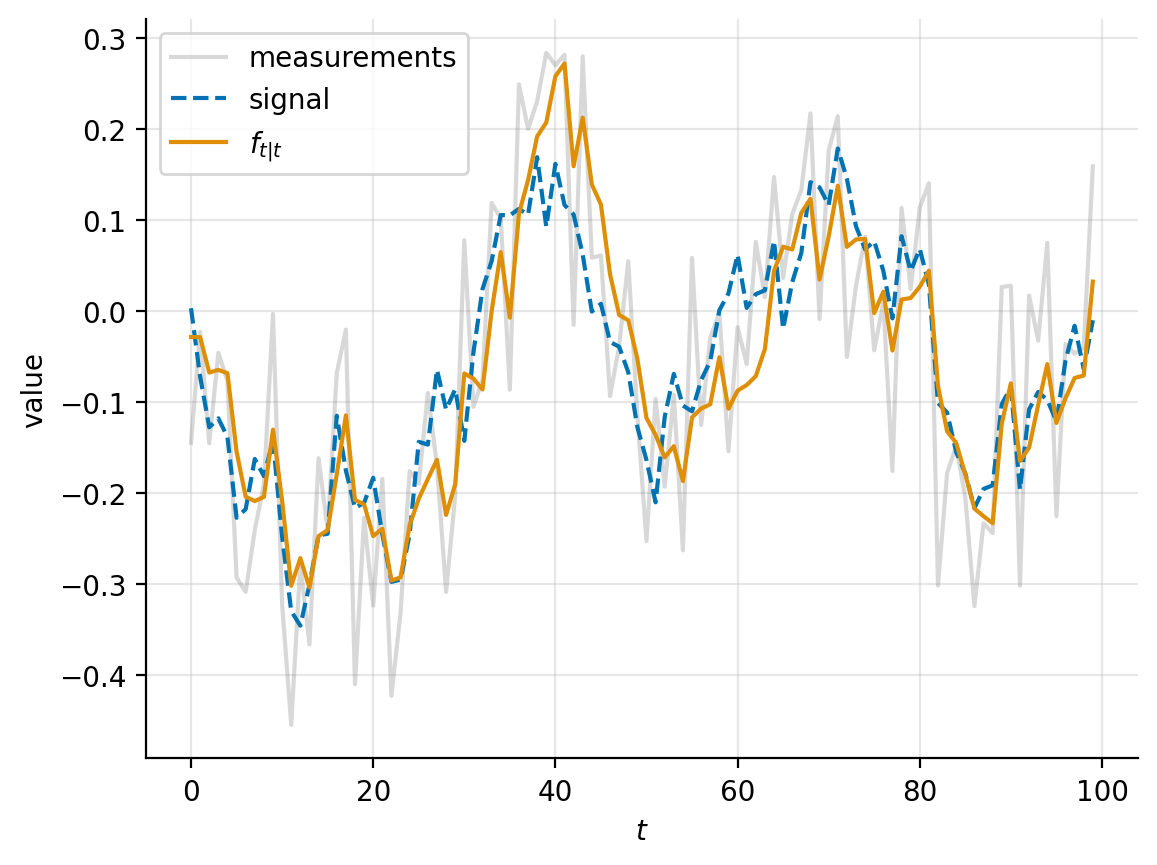

In [315]:
s = 3
tmask = jnp.tril(jnp.ones((n_steps, n_steps)), k=0)
blup = jnp.einsum("tk,k,k,tk->t", cov_fe, 1 / R ** 2, innovations_test[:, s], tmask)

plt.plot(xrange, measurements_test[:, s], label="measurements", alpha=0.3, c="gray")
plt.plot(xrange, signals_test[:, s], label="signal", linestyle="--")
plt.plot(xrange, blup, label="$f_{t|t}$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("value")
plt.grid(alpha=0.3)

## k-step ahead prediction — $f_{t+k|t}$
For $t=1,\ldots,T$.

$$
\begin{aligned}
    f_{t|T}
    &= \sum_{k=1}^t\,{\rm Cov}(f_t, \varepsilon_k)\,R_k^{-1}\,\varepsilon_k\\
    &= \sum_{k=1}^T\,{\rm Cov}(f_t, \varepsilon_k)\,R_k^{-1}\,\varepsilon_k\,{\bf 1}(k \leq t)\\
\end{aligned}
$$

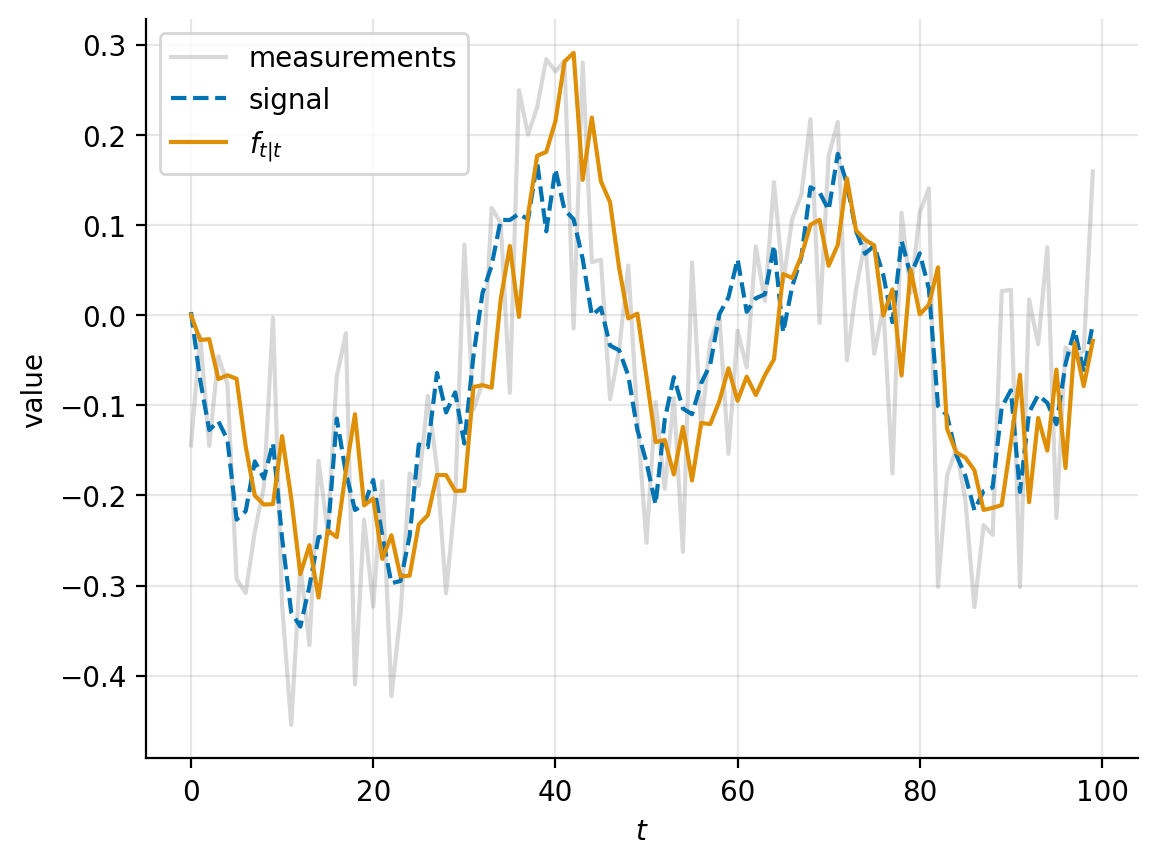

In [316]:
s = 3
k = -1
tmask = jnp.tril(jnp.ones((n_steps, n_steps)), k=-1)
blup = jnp.einsum("tk,k,k,tk->t", cov_fe, 1 / R ** 2, innovations_test[:, s], tmask)

plt.plot(xrange, measurements_test[:, s], label="measurements", alpha=0.3, c="gray")
plt.plot(xrange, signals_test[:, s], label="signal", linestyle="--")
plt.plot(xrange, blup, label="$f_{t|t}$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("value")
plt.grid(alpha=0.3)

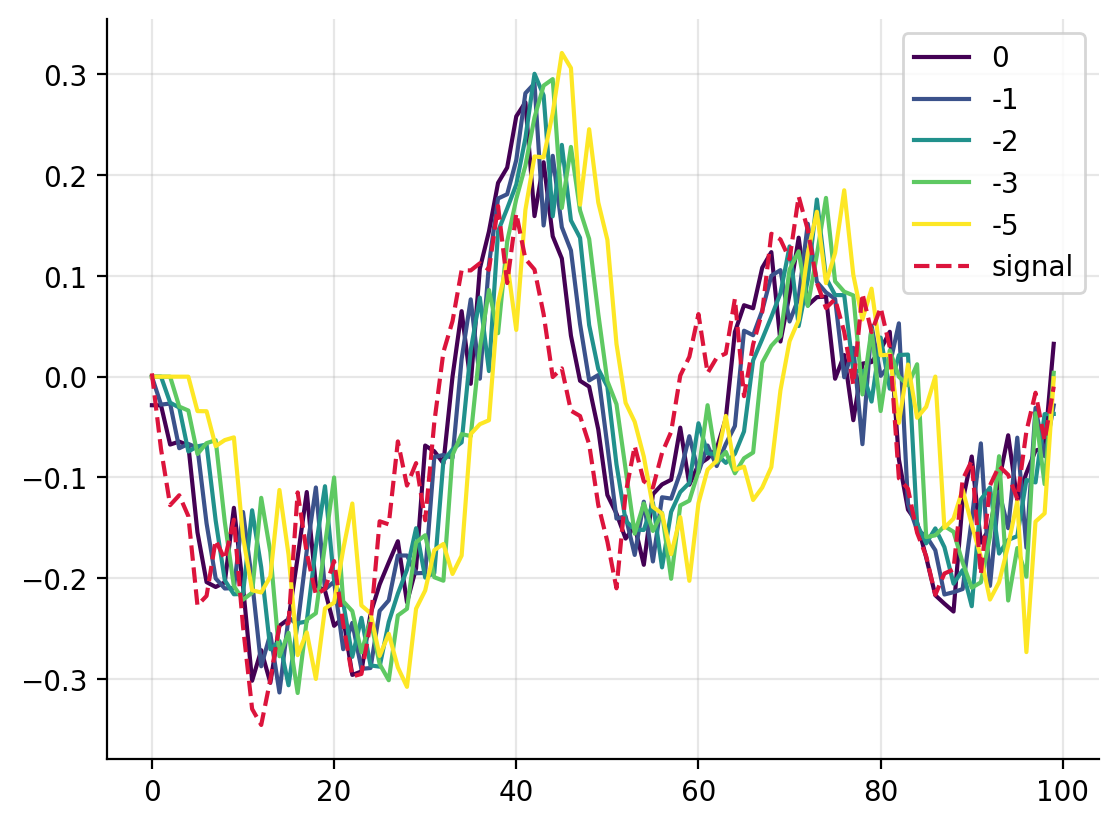

In [317]:
k_values = [0, -1, -2, -3, -5]
nk = len(k_values)
s = 3
colors = plt.cm.viridis(jnp.linspace(0, 1, nk))
for color, k in zip(colors, k_values):
    tmask = jnp.tril(jnp.ones((n_steps, n_steps)), k=k)
    blup = jnp.einsum("tk,k,k,tk->t", cov_fe, 1 / R ** 2, innovations_test[:, s], tmask)
    plt.plot(xrange, blup, color=color, label=k)
plt.plot(xrange, signals_test[:, s], label="signal", linestyle="--", c="crimson")
plt.legend()
plt.grid(alpha=0.3)

## Fixed-lag smoothing — $f_{t|t+k}$
For $t=1,\ldots,T$.

$$
\begin{aligned}
    f_{t|T}
    &= \sum_{k=1}^t\,{\rm Cov}(f_t, \varepsilon_k)\,R_k^{-1}\,\varepsilon_k\\
    &= \sum_{k=1}^T\,{\rm Cov}(f_t, \varepsilon_k)\,R_k^{-1}\,\varepsilon_k\,{\bf 1}(k \leq t)\\
\end{aligned}
$$

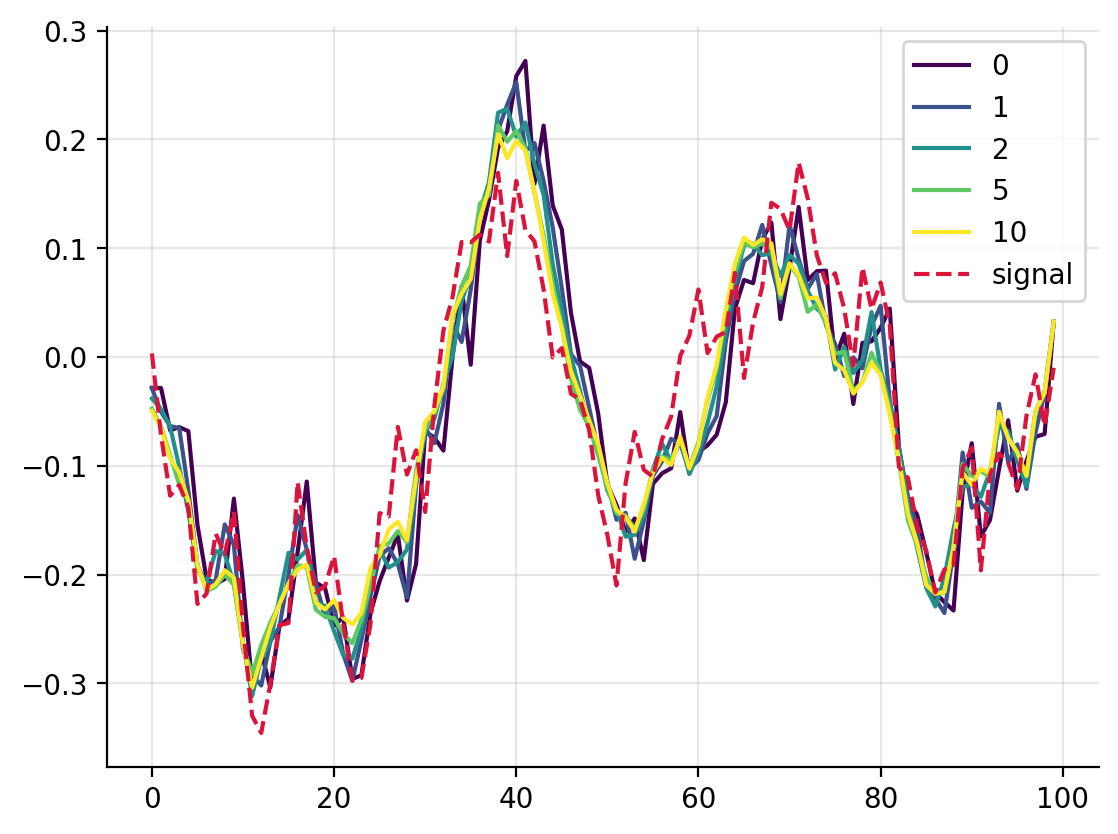

In [318]:
s = 3
k_values = [0, 1, 2, 5, 10]
nk = len(k_values)
colors = plt.cm.viridis(jnp.linspace(0, 1, nk))
for color, k in zip(colors, k_values):
    tmask = jnp.tril(jnp.ones((n_steps, n_steps)), k=k)
    blup = jnp.einsum("tk,k,k,tk->t", cov_fe, 1 / R ** 2, innovations_test[:, s], tmask)
    plt.plot(xrange, blup, color=color, label=k)
plt.plot(xrange, signals_test[:, s], label="signal", linestyle="--", c="crimson")
plt.legend()
plt.grid(alpha=0.3)